# SOLVING THE 2D HEAT EQUATION - IMPLICIT

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://jupyter.lai.gwu.edu/user/nbakr10/notebooks/numerical-mooc/lessons/04_spreadout/figures/2dchip.svg")

In [31]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot
%matplotlib inline

In [39]:
#set the parameters
L= 0.01
nx, ny = 21, 21
dx = L / (nx - 1)
dy = L / (ny - 1)
x = np.linspace(0, L, num=nx)
y = np.linspace(0, L, num=ny)
alpha = 1e-4

#set the initial condition
T0 = np.full((ny, nx), 20.0)
Tb = 100.0
T0[:, 0] = 100.0 #bottom
T0[0, :] = 100.0 #left

In [40]:
def btcs(T0, nt, dt, dx, alpha, Tb):
    
    sigma = alpha * dt / dx**2
    ny, nx = T0.shape
    M, N = nx - 2, ny - 2
    
    #assemble the LHS operator from the function
    A = lhs_operator(M, N, sigma)
    
    #get the temperature as a 1D array
    T = T0[1:-1, 1:-1].flatten()   #interior points as a 1d array
    
    #integrate in time
    for n in range(nt):
        b = rhs_vector(T, M, N, sigma, Tb)
        T = np.linalg.solve(A, b)
    
    
    #I, J = int(M/2), int(N/2) # indices at the center of the chip to know when it is 70 degrees
    
    return map_1d_to_2d(T, nx, ny, Tb)

In [41]:
def lhs_operator(M, N, sigma):
    
    A = np.zeros((M * N, M * N))
    
    for j in range(N):
        
        for i in range(M):
            
            I = j * M + i
            
            south = I - M
            west = I - 1
            east = I + 1
            north = I + M
            
            #set up coefficients at the corner points
            if i == 0 and j == 0:  # bottom-left corner
                A[I, I] = 1.0 / sigma + 4.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1 and j == 0:  # bottom-right corner
                A[I, I] = 1.0 / sigma + 3.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif i == 0 and j == N - 1:  # top-left corner
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, east] = -1.0
            elif i == M - 1 and j == N - 1:  # top-right corner
                A[I, I] = 1.0 / sigma + 2.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                
                
            # Setup coefficients at side points (excluding corners).
            elif i == 0:  # left side
                A[I, I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1:  # right side
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif j == 0:  # bottom side
                A[I, I] = 1.0 / sigma + 4.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif j == N - 1:  # top side
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                
            
            # Setup coefficients at interior points.
            else:
                A[I, I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
    return A

In [42]:
def rhs_vector(T, M, N, sigma, Tb):
    
    b = 1.0 / sigma * T
    
    # Add Dirichlet term at points located next
    # to the left and bottom boundaries.
    
    for j in range(N):
        for i in range(M):
            I = j * M + i
            if i == 0:
                b[I] += Tb
            if j == 0:
                b[I] += Tb
    return b

In [43]:
def map_1d_to_2d(T_1d, nx, ny, Tb):
    
    T = np.zeros((ny, nx))
    
    # Get the value at interior points.
    T[1:-1, 1:-1] = T_1d.reshape((ny - 2, nx - 2))
    
    # Use Dirichlet condition at left and bottom boundaries.
    T[:, 0] = Tb
    T[0, :] = Tb
    
    # Use Neumann condition at right and top boundaries.
    T[:, -1] = T[:, -2]
    T[-1, :] = T[-2, :]
    
    return T

In [44]:
sigma = 0.25
dt = sigma * min(dx, dy)**2 / alpha  # time-step size
nt = 300  # number of time steps to compute

T = btcs(T0, nt, dt, dx, alpha, Tb)


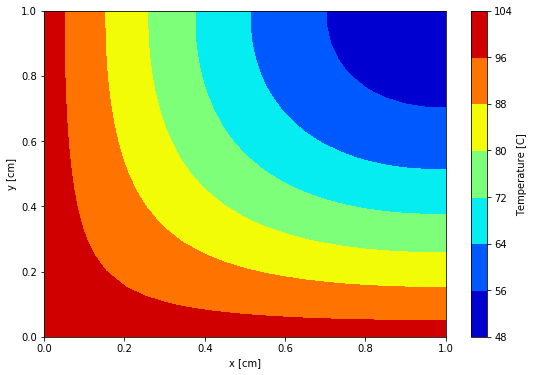

In [45]:
pyplot.figure(figsize=(9.0, 6.0))
pyplot.xlabel('x [cm]')
pyplot.ylabel('y [cm]')
contf = pyplot.contourf(x * 100, y * 100, T, cmap = 'jet');
cbar = pyplot.colorbar(contf)
cbar.set_label('Temperature [C]')